**Part 1 of 2 of the modelling notebook: Topic Modelling**

The original notebook is split into 2 parts due to its length. 
<br>This notebook involves the use of topic modelling while the next part involves the use of decision tree, random forest, and kNN. 

A separate Excel file records certain steps and results. It serves as an experiment log, and helps the notebook to run smoother.

# Loading in libraries

In [1]:
import pandas as pd

In [1]:
# For NLP
import nltk 
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /Users/onion/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/onion/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# For NLP
import contractions
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
import re

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve

In [47]:
# Loading in the dataset from combined EDA efforts with features combined
df = pd.read_excel('/final_submission/final.xlsx')

In [4]:
df.head()

,year,rank,song,artist,genre,popularity,explicit,album,release_year,release_month,...,time_signature,lyrics,genre_split,lyrics_length,topic,contrib_perc,lyric_pos,lyric_neu,lyric_neg,hit
0,1990,1,Hold On,Wilson Phillips,"['girl group,mellow gold,new wave pop,soft rock']",70,0,Wilson Phillips,1990,5,...,4,I know this pain (I know this pain) Why do you...,soft rock,2129,T5,0.318288,0,0,1,0
1,1990,2,It Must Have Been Love,Roxette,"['europop,new wave pop,soft rock,swedish pop']",75,0,It Must Have Been Love,1990,5,...,4,It must have been love But it's over now Lay a...,swedish pop,1380,T3,0.443180,1,0,0,1
2,1990,3,Nothing Compares 2 U,Sinead O'Connor,"['lilith,new wave pop,pop rock']",60,0,I Do Not Want What I Haven't Got,1990,7,...,4,It's been seven hours and fifteen days Since y...,pop rock,1094,T3,0.706082,0,0,1,0
3,1990,4,Poison,Bell Biv DeVoe,"['boy band,contemporary r&b,hip hop,hip pop,ne...",70,0,Poison,1990,1,...,4,"Yeah, Spyderman and Freeze in full effect Uh-h...",urban contemporary,2284,T3,0.547235,1,0,0,0
4,1990,5,Vogue,Madonna,"['dance pop,pop']",67,0,Celebration (double disc version),1989,9,...,4,"Strike a pose Strike a pose Vogue (Vogue, vogu...",pop,2259,T1,0.467808,1,0,0,0


In [48]:
print(df.keys())

Index(['year', 'rank', 'song', 'artist', 'genre', 'popularity', 'explicit',
       'album', 'release_year', 'release_month', 'danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_m',
       'time_signature', 'lyrics', 'genre_split', 'lyrics_length', 'topic',
       'contrib_perc', 'lyric_pos', 'lyric_neu', 'lyric_neg', 'hit'],
      dtype='object')


In [49]:
# They are dropped as topic modelling will be attempted here
df = df.drop(columns=['lyrics_length', 'topic', 'contrib_perc'])

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2931 entries, 0 to 2930
Data columns (total 29 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   year              2931 non-null   int64  
 1   rank              2931 non-null   int64  
 2   song              2931 non-null   object 
 3   artist            2931 non-null   object 
 4   genre             2931 non-null   object 
 5   popularity        2931 non-null   int64  
 6   explicit          2931 non-null   int64  
 7   album             2931 non-null   object 
 8   release_year      2931 non-null   int64  
 9   release_month     2931 non-null   int64  
 10  danceability      2931 non-null   float64
 11  energy            2931 non-null   float64
 12  key               2931 non-null   int64  
 13  loudness          2931 non-null   float64
 14  mode              2931 non-null   int64  
 15  speechiness       2931 non-null   float64
 16  acousticness      2931 non-null   float64


Columns successfully deleted and variables look to be in the correct data types.

# Text wrangling

## Pre-processing

Contractions are common in lyrics given its length such as in these randomly selected songs:

In [8]:
# Sinead O'Connor's Nothing Compares 2 U
df.iat[2,23]

'It\'s been seven hours and fifteen days Since you took your love away I go out every night and sleep all day Since you took your love away Since you\'ve been gone I can do whatever I want I can see whomever I choose I can eat my dinner in a fancy restaurant But nothing... I said nothing can take away these blues \'Cause nothing compares Nothing compares to you It\'s been so lonely without you here Like a bird without a song Nothing can stop these lonely tears from falling Tell me, baby, where did I go wrong I could put my arms around every boy I see But they\'d only remind me of you I went to the doctor and guess what he told me, guess what he told me? He said, "Girl, you better try to have fun no matter what you do," but he\'s a fool \'Cause nothing compares Nothing compares to you All the flowers that you planted, mama, in the back yard All died when you went away I know that living with you, baby, was sometimes hard But I\'m willing to give it another try Nothing compares Nothing c

In [9]:
# The Weekend's Blinding Lights
df.iat[2754,23]

"Yeah I've been tryna call I've been on my own for long enough Maybe you can show me how to love, maybe I'm going through withdrawals You don't even have to do too much You can turn me on with just a touch, baby I look around and Sin City's cold and empty (Oh) No one's around to judge me (Oh) I can't see clearly when you're gone I said, ooh, I'm blinded by the lights No, I can't sleep until I feel your touch I said, ooh, I'm drowning in the night Oh, when I'm like this, you're the one I trust Hey, hey, hey I'm running out of time 'Cause I can see the sun light up the sky So I hit the road in overdrive, baby, oh The city's cold and empty (Oh) No one's around to judge me (Oh) I can't see clearly when you're gone I said, ooh, I'm blinded by the lights No, I can't sleep until I feel your touch I said, ooh, I'm drowning in the night Oh, when I'm like this, you're the one I trust Related Songs I'm just calling back to let you know (Back to let you know) I could never say it on the phone (Say

In [10]:
# Rubben Studdard's Sorry
df.iat[1305,23]

"(I'm sorry) (I'm Sorry) It's like I missed a shot It's like I dropped the ball (Damn I'm Sorry) It's like I'm on stage And I forgot the words (Damn, I'm sorry) It's like building a new house With no roof and no doors (Damn, I'm sorry) It's like trying to propose And I ain't got the ring (Oooh damn I'm sorry) But girl I've apologized A million times before (I'll apologize a million more) So here it comes again For all the wrong I've done (so get ready babe) Here's One million one Girl this is my sorry for, 2004 And I ain't gonna mess up no more, this year I'm 'a take this one chance And make it real clear I'm sorry for May And I'm sorry for June (for real) And I'm sorry for July (i am) In case I don't tell you August, September, October, November 'till your December I'm Sorry (I'm sorry 2004) Its like stayin' out at night Had way too much to drink (Damn, I'm sorry) It's like you change your hair And I don't say a thing (Damn I'm sorry) It's like we're fallin' fast asleep With no kiss, 

Also noted there are a fair amount of digits and punctuations in the lyrics. Additionally there is usually a number followed by the word "Embed". It could be a result of the scraping. But first, expand out the contractions with a library that is capable of expanding contractions and slangs such as:
* you're -> you are
* i'm    -> I am
* ima    -> I am going to
* yall  -> you all
* gotta  -> got to [1]

In [51]:
# Expand out the contractions

df['expanded'] = df['lyrics'].apply(lambda x: [contractions.fix(word) for word in x.split()])

In [22]:
# Check df.iat[2754,23]
df.iloc[[2754], [23, 29]]

,lyrics,expanded
2754,Yeah I've been tryna call I've been on my own ...,"[Yeah, I have, been, tryna, call, I have, been..."


In [20]:
# Examine the content of a specific cell
df.iat[2754,29]

['Yeah',
 'I have',
 'been',
 'tryna',
 'call',
 'I have',
 'been',
 'on',
 'my',
 'own',
 'for',
 'long',
 'enough',
 'Maybe',
 'you',
 'can',
 'show',
 'me',
 'how',
 'to',
 'love,',
 'maybe',
 'I am',
 'going',
 'through',
 'withdrawals',
 'You',
 'do not',
 'even',
 'have',
 'to',
 'do',
 'too',
 'much',
 'You',
 'can',
 'turn',
 'me',
 'on',
 'with',
 'just',
 'a',
 'touch,',
 'baby',
 'I',
 'look',
 'around',
 'and',
 'Sin',
 "City's",
 'cold',
 'and',
 'empty',
 '(Oh)',
 'No',
 "one's",
 'around',
 'to',
 'judge',
 'me',
 '(Oh)',
 'I',
 'cannot',
 'see',
 'clearly',
 'when',
 'you are',
 'gone',
 'I',
 'said,',
 'ooh,',
 'I am',
 'blinded',
 'by',
 'the',
 'lights',
 'No,',
 'I',
 'cannot',
 'sleep',
 'until',
 'I',
 'feel',
 'your',
 'touch',
 'I',
 'said,',
 'ooh,',
 'I am',
 'drowning',
 'in',
 'the',
 'night',
 'Oh,',
 'when',
 'I am',
 'like',
 'this,',
 'you are',
 'the',
 'one',
 'I',
 'trust',
 'Hey,',
 'hey,',
 'hey',
 'I am',
 'running',
 'out',
 'of',
 'time',
 'Becau

From the above examination, it appears that the last word 'embed' could be joint to other words of the lyric. That needs to be kept in mind when removing it later.

In [52]:
# Convert the lists back into string for tokenization later

df['str'] = [' '.join(map(str, l)) for l in df['expanded']]

In [25]:
# Check
df.iloc[[2754], [23, 29, 30]]

,lyrics,expanded,str
2754,Yeah I've been tryna call I've been on my own ...,"[Yeah, I have, been, tryna, call, I have, been...",Yeah I have been tryna call I have been on my ...


## Cleaning

*I'm blue
<br>Da ba dee da ba di<br>
Da ba dee da ba di...*

In [69]:
# Import stopwords to remove words that commonly
# appear in text but do not add a lot of meaning and analysis value like 'a'
from nltk.corpus import stopwords  
stop_words = set(stopwords.words("english"))

# Add words not in the NLTK stopwords list- mostly melodic words
new_stopwords = ['ooh','yeah','hey','whoa','woah', 'ohh', 'was', 'mmmm', 
                 'oooh','yah','yeh','mmm', 'hmm','deh','doh','jah','hmmm']
stopwords = stop_words.union(new_stopwords)

In [54]:
def preprocess(text):
    '''perform some preliminary cleaning to text'''
    
    # Convert text to lower cases
    text = text.lower() 
    # Remove words with less than 3 characters like oh, la
    text = re.sub(r'\b\w{1,3}\b',' ',text)
    # Remove punctuation
    text= re.sub(r'[^\w\s]', '', str(text))  
    # Remove the digits
    text = re.sub(r'\d',' ',text)
    # Remove the word "embed" at the end of each lyric
    text = re.sub(r'(?:embed)', '',text)
    # Replace subsequent whitespace(s) with a single whitespace
    text = re.sub('\s+', ' ', text) 
    text = [w for w in text.split() if w not in set(stopwords)]
    return ' '.join(text)

# Apply function
df['cleaned'] = df['str'].apply(preprocess)

In [30]:
# Display
df.iloc[[2754], [23, 29, 30,31]]

,lyrics,expanded,str,cleaned
2754,Yeah I've been tryna call I've been on my own ...,"[Yeah, I have, been, tryna, call, I have, been...",Yeah I have been tryna call I have been on my ...,tryna call long enough maybe show love maybe g...


In [33]:
# Check: The Weekend's Blinding Lights
df.iat[2754,31]

'tryna call long enough maybe show love maybe going withdrawals even much turn touch baby look around city cold empty around judge cannot clearly gone said blinded lights cannot sleep feel touch said drowning night like trust running time light road overdrive baby city cold empty around judge cannot clearly gone said blinded lights cannot sleep feel touch said drowning night like trust related songs calling back know back know could never phone phone never time said blinded lights cannot sleep feel touch said blinded lights cannot sleep feel touch'

In [35]:
# Check: Sinead O'Connor's Nothing Compares 2 U
df.iat[2,31]

'seven hours fifteen days since took love away every night sleep since took love away since gone whatever want whomever choose dinner fancy restaurant nothing said nothing take away blues nothing compares nothing compares lonely without like bird without song nothing stop lonely tears falling tell baby wrong could arms around every would remind went doctor guess told guess told said girl better matter fool nothing compares nothing compares flowers planted mama back yard died went away know living baby sometimes hard willing give another nothing compares nothing compares nothing compares nothing compares nothing compares nothing compares'

In [34]:
# Check: Rubben Studdard's Sorry
df.iat[1305,31]

'sorry sorry like missed shot like dropped ball damn sorry like stage forgot words damn sorry like building house roof doors damn sorry like trying propose ring damn sorry girl apologized million times apologize million comes wrong done ready babe million girl sorry going mess year take chance make real clear sorry sorry june real sorry july case tell august september october november till december sorry sorry like stayin night much drink damn sorry like change hair thing damn sorry like fallin fast asleep kiss sorry like forgot gift damn sorry girl apologized million times apologize million comes wrong done ready babe million girl sorry going mess year take chance take time make real clear sorry sorry june real sorry july case tell august september october november till december sorry sorry sorry sorry bottom heart hurt girl sorry weekends sorry weekdays sorry things sorry things said sorry lies sorry time want like tell sorry babe sorry sorry oooooooooooooohhhhhhh wooooooooh strip cl

## Lemmatisation

**(a) Part of Speech (POS) tagging**

In [55]:
from nltk import pos_tag

# Mapping pos tags
def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

**(b) Lemmas proper**

In [56]:
# Lemmatizing 
import string

def clean_text(text):
    # Split the lyrics
    text = [word.strip(string.punctuation) for word in text.split()]
    pos_tags = pos_tag(text)
    # Using lemmatiser from WordNet
    lemmatizer = WordNetLemmatizer()
    # Identify correct part of speech and convert them back to dictionary form
    text = [lemmatizer.lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # Join them back
    text = " ".join(text)
    return(text)

# Apply lemmatisation function
df["lemmas"]= df['cleaned'].apply(clean_text)

In [46]:
df.iloc[[2754], [23, 29, 30,31, 32]]

,lyrics,expanded,str,cleaned,lemmas
2754,Yeah I've been tryna call I've been on my own ...,"[Yeah, I have, been, tryna, call, I have, been...",Yeah I have been tryna call I have been on my ...,tryna call long enough maybe show love maybe g...,tryna call long enough maybe show love maybe g...


In [48]:
# Check: Sinead O'Connor's Nothing Compares 2 U
df.iat[2,32]

'seven hour fifteen day since take love away every night sleep since take love away since go whatever want whomever choose dinner fancy restaurant nothing say nothing take away blue nothing compare nothing compare lonely without like bird without song nothing stop lonely tear fall tell baby wrong could arm around every would remind go doctor guess tell guess tell say girl well matter fool nothing compare nothing compare flower plant mama back yard die go away know live baby sometimes hard willing give another nothing compare nothing compare nothing compare nothing compare nothing compare nothing compare'

In [49]:
# Check: The Weekend's Blinding Lights
df.iat[2754,32]

'tryna call long enough maybe show love maybe go withdrawal even much turn touch baby look around city cold empty around judge cannot clearly go say blind light cannot sleep feel touch say drown night like trust run time light road overdrive baby city cold empty around judge cannot clearly go say blind light cannot sleep feel touch say drown night like trust relate song call back know back know could never phone phone never time say blinded light cannot sleep feel touch say blinded light cannot sleep feel touch'

In [57]:
# Drop previous lyrics related columns now that the lyrics have 
# been cleaned and lemmatised
df = df.drop(columns=['lyrics', 'expanded', 'str', 'cleaned'])

In [58]:
# Re-name the lemmas to lyrics
df.rename(columns= {'lemmas':'lyrics'}, inplace= True)

In [13]:
# Check
print(df.keys())

Index(['year', 'rank', 'song', 'artist', 'genre', 'popularity', 'explicit',
       'album', 'release_year', 'release_month', 'danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_m',
       'time_signature', 'genre_split', 'lyric_pos', 'lyric_neu', 'lyric_neg',
       'hit', 'lyrics'],
      dtype='object')


In [6]:
# Tokenize the text
df['tokens'] = df['lyrics'].apply(word_tokenize)

In [16]:
# Check
df.iloc[[2754], [28,29]]

,lyrics,tokens
2754,tryna call long enough maybe show love maybe g...,"[tryna, call, long, enough, maybe, show, love,..."


In [60]:
# Saving the dataframe to csv file
df.to_csv('tokenise.csv', index= False)

In [4]:
#df = pd.read_csv('/Final_submission/22a204h/tokenise.csv')

In [ ]:
#df.head()

# Gensim LDA model training

## Dictionary and corpus creation

**Dictionary Creation and occurrence-based filtering**

Gensim will first be used to perform Latent Dirichlet Allocation (LDA) for the topic modelling, which requires a dictionary representation of the documents. It involves mapping all the tokens to a unique ID, which reduces the overall dimensionality of a literature corpus[2]. Additionally tokens that occur in less than 100 songs, or tokens that occur in more than 80% of songs will be filtered out [3].

In [8]:
import gensim.corpora as corpora

# Create dictionary
dictionary = corpora.Dictionary(df['tokens'])

# Filter out token as per criteria mentioned above
# no_below= tokens that occur in less than 100 songs
# no_above= that occur in more than 80% of songs
dictionary.filter_extremes(no_below = 100, no_above = 0.8)

**Bag-of-Words and Index to Dictionary Conversion**

Each song (already transformed into a list of tokens) is converted into the bag-of-words format, which only stores the unique token ID and its count for each song [4].

In [9]:
# Create Corpus
texts = df['tokens']
# Convert each song to bag-of-words 
corpus = [dictionary.doc2bow(text) for text in texts]

In [21]:
# View
print(corpus[:1][0][:30])

[(0, 3), (1, 7), (2, 3), (3, 1), (4, 4), (5, 8), (6, 1), (7, 1), (8, 1), (9, 2), (10, 7), (11, 4), (12, 1), (13, 24), (14, 1), (15, 12), (16, 1), (17, 1), (18, 7), (19, 1), (20, 3), (21, 1), (22, 1), (23, 5), (24, 1), (25, 3), (26, 1), (27, 1), (28, 13), (29, 1)]


## Modelling

In [10]:
# chunksize= the number of documents processed at a time in the training algorithm [5]
chunksize = 200
# passes= how often the model is trained on the entire corpus [5]
passes = 20
# Number of topics set at 6 as from EDA, there are approximately
# 6 main music genre: Urban contemporary, pop, rock, R&B, rap, hip hop
num_topics = 6

In [11]:
# Training the model
from gensim.models import LdaModel
lda_model = LdaModel(
corpus=corpus,
id2word=dictionary,
chunksize=chunksize,
alpha='auto',
eta='auto',
num_topics=num_topics,
random_state=42,
passes=passes)

In [12]:
from pprint import pprint

# Print the top 10 words in the 6 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.076*"bitch" + 0.073*"nigga" + 0.063*"shit" + 0.062*"fuck" + 0.043*"money" '
  '+ 0.037*"like" + 0.021*"real" + 0.019*"back" + 0.018*"tryna" + '
  '0.017*"ride"'),
 (1,
  '0.130*"like" + 0.038*"come" + 0.029*"girl" + 0.024*"make" + 0.021*"back" + '
  '0.019*"body" + 0.019*"look" + 0.018*"dance" + 0.018*"right" + 0.017*"hand"'),
 (2,
  '0.038*"never" + 0.035*"time" + 0.031*"feel" + 0.027*"life" + 0.027*"would" '
  '+ 0.025*"could" + 0.023*"night" + 0.022*"good" + 0.022*"know" + '
  '0.021*"take"'),
 (3,
  '0.073*"can" + 0.073*"not" + 0.071*"go" + 0.029*"heart" + 0.027*"give" + '
  '0.027*"keep" + 0.027*"back" + 0.025*"break" + 0.019*"make" + 0.018*"wait"'),
 (4,
  '0.315*"love" + 0.233*"baby" + 0.027*"babe" + 0.026*"come" + 0.026*"need" + '
  '0.022*"give" + 0.021*"girl" + 0.015*"feel" + 0.014*"touch" + '
  '0.014*"nobody"'),
 (5,
  '0.138*"want" + 0.103*"know" + 0.043*"need" + 0.037*"tell" + 0.028*"think" + '
  '0.027*"girl" + 0.021*"call" + 0.020*"thing" + 0.020*"really" + '


## Evaluation

Coherence measure is used for Gensim LDA models. It is a measure of the degree of semantic similarity between high scoring words in the topic [6]. There are several types of coherence measures and CV coherence score and UMass coherence score.

In [27]:
# c_v score
from gensim.models.coherencemodel import CoherenceModel

coherencemodel = CoherenceModel(model=lda_model, texts=df['tokens'], 
                                dictionary=dictionary, coherence='c_v')
print(coherencemodel.get_coherence())

0.4072156563647125


CV coherence score is calculated using a sliding window, a one-set segmentation of the top words and an indirect confirmation measure that uses normalized pointwise mutual information (NPMI) and the cosine similarity [7]. It ranges between 0 and 1, the higher it is, the greater the coherence in a topic [8]. 

The score achieved is less than the half way of the scoring range indicating that coherence is not very ideal within a topic. The topics are visualised using pyLDAvis (a copy of the visualisation is saved. It is recorded in the experiment log too) and as is expected with the low coherence score, some large bubbles/ prevalent topics displaying obvious overlapping indicating the topics are not well distinguished [4].

In [ ]:
# Visualise
gensim_vis= gensimvis.prepare(lda_model, corpus, dictionary)
# Saving the visualisation to a html file and submitted together 
# with notebook
pyLDAvis.save_html(gensim_vis, 'gensim_vis.html')

**Subsequent correction:**
At the time of coding, there was no realisation that there are some issues with the CV score and the author of the library does not recommend using it anymore [7, 9]. 

Upon discovering that issue, the UMass coherence score is used instead. The UMass score measures the document frequency of two words appearing together, with higher score indicating that two words are appearing in a lot of documents relative to how often just one of the words appearing in documents [10]. The negative score indicates that two words do not appear in documents together very frequently.

In [13]:
# u_mass
coherencemodel = CoherenceModel(model=lda_model, corpus=corpus, 
                                dictionary=dictionary, coherence='u_mass')
print(coherencemodel.get_coherence())

-1.4369366613793304


In [31]:
# Saving the first LDA attempt
import pickle

pickle.dump(lda_model, open('lda1.pkl','wb'))

## Finding the optimal number of topics

The function used in this section is from [15].

### Initial parameters

**Searching optimal number of topics with initial parameters of chunksize = 200, passes = 20:**

In [70]:
# Initial params with c_v score
# Number of topics start at 5, increasing in steps of 5
def compute_coherence_values(dictionary, corpus, texts, limit, start=5, step=5):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, 
                         random_state=42, chunksize = 200, passes = 20)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=df['tokens'], dictionary=dictionary, 
                                        coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [15]:
# Initial params using u_mass score
# # Number of topics start at 5, increasing in steps of 5
def compute_coherence_values(dictionary, corpus, texts, limit, start=5, step=5):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, 
                         random_state=42, chunksize = 200, passes = 20)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, corpus=corpus, dictionary=dictionary, 
                                        coherence='u_mass')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [20]:
# Initial params with u_mass score
# Number of topics start at 2, increasing in steps of 2
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=2):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, 
                         random_state=42, chunksize = 200, passes = 20)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, corpus=corpus, dictionary=dictionary, coherence='u_mass')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [16]:
# Call search function starting at 5 topics, it is capped at 25 topics
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=df['tokens'], start=5, limit=25, step=5)

In [21]:
# Call search function starting at 2 topics, it is capped at 10 topics
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, 
                                                        corpus=corpus, texts=df['tokens'], 
                                                        start=2, limit=10, step=2)

In [47]:
# Print the coherence scores for c_v
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 3))

Num Topics = 5  has Coherence Value of 0.377
Num Topics = 10  has Coherence Value of 0.372
Num Topics = 15  has Coherence Value of 0.374
Num Topics = 20  has Coherence Value of 0.363


In [19]:
# Print the coherence scores for u_mass
for m, mass in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(mass, 3))

Num Topics = 5  has Coherence Value of -1.246
Num Topics = 10  has Coherence Value of -1.573
Num Topics = 15  has Coherence Value of -1.76
Num Topics = 20  has Coherence Value of -1.793


In [23]:
# Print the coherence scores for u_mass with 
# smaller steps and starting topics
for m, s_mass in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(s_mass, 3))

Num Topics = 2  has Coherence Value of -0.973
Num Topics = 4  has Coherence Value of -1.115
Num Topics = 6  has Coherence Value of -1.351
Num Topics = 8  has Coherence Value of -1.496


From the results above, it is noticed that for CV scoring, none of them are as good as the score for 6 topics. According to UMass the optimal number of topics is 2 as it has the greatest negative value, indicating the highest score among the searches.

### Default params

In [48]:
# Default params with c_v score
# Number of topics start at 5, increasing in steps of 5

def compute_coherence_values(dictionary, corpus, texts, limit, start=5, step=5):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, random_state=42)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=df['tokens'], dictionary=dictionary, 
                                        coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
# Default params with u_mass
# Number of topics start at 5, increasing in steps of 5

def compute_coherence_values(dictionary, corpus, texts, limit, start=5, step=5):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, random_state=42)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, corpus=corpus, dictionary=dictionary, 
                                        coherence='u_mass')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [24]:
# Call search function starting at 5 topics, it is capped at 25 topics
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, 
                                                        corpus=corpus, texts=df['tokens'], 
                                                        start=5, limit=25, step=5)

In [51]:
# Print the coherence scores- CV
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 3))

Num Topics = 5  has Coherence Value of 0.348
Num Topics = 10  has Coherence Value of 0.349
Num Topics = 15  has Coherence Value of 0.342
Num Topics = 20  has Coherence Value of 0.338


In [26]:
# Print the coherence scores- Umass
for m, mass2 in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(mass2, 3))

Num Topics = 5  has Coherence Value of -1.246
Num Topics = 10  has Coherence Value of -1.573
Num Topics = 15  has Coherence Value of -1.76
Num Topics = 20  has Coherence Value of -1.793


The UMass scores are the same as those searched with initial parameters while there is no significant improvement for CV scores. 

### Increased chunk size and passes

In [56]:
# Increase chunksize and passes for CV score
def compute_coherence_values(dictionary, corpus, texts, limit, start=5, step=5):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, 
                         random_state=42, chunksize = 500, passes = 50)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=df['tokens'], dictionary=dictionary, 
                                        coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [27]:
# Increase chunksize and passes for UMass score
def compute_coherence_values(dictionary, corpus, texts, limit, start=5, step=5):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, 
                         random_state=42, chunksize = 500, passes = 50)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, corpus=corpus, dictionary=dictionary, 
                                        coherence='u_mass')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [31]:
# Increase chunksize and passes; smaller start and steps 
# with number of topics narrowed down - UMass score

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=2):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, 
                         random_state=42, chunksize = 500, passes = 50)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, corpus=corpus, dictionary=dictionary, 
                                        coherence='u_mass')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [28]:
# Call search function starting at 5 topics, it is capped at 25 topics
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, 
                                                        corpus=corpus, texts=df['tokens'], 
                                                        start=5, limit=25, step=5)

In [32]:
# Call search function starting at 2 topics, it is capped at 10 topics
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, 
                                                        corpus=corpus, texts=df['tokens'], 
                                                        start=2, limit=10, step=2)

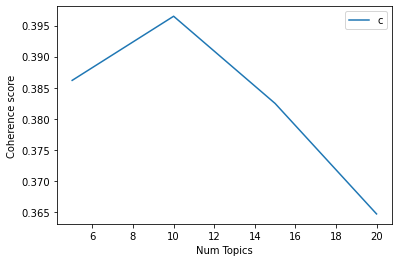

In [58]:
# Visualise topic number search for c_v
limit=25; start=5; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

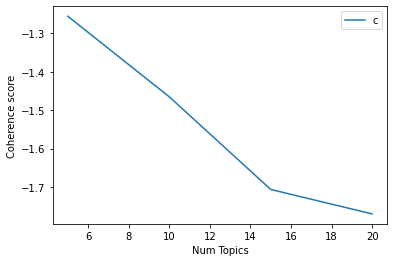

In [29]:
# Visualise topic number search for u_mass
limit=25; start=5; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

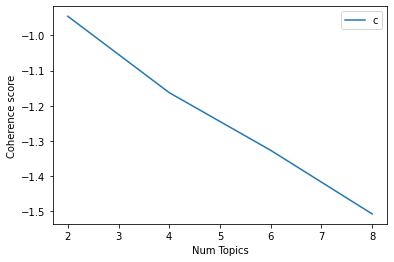

In [33]:
# Visualise narrowed down range for topics for Umass score
limit=10; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [59]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 3))

Num Topics = 5  has Coherence Value of 0.386
Num Topics = 10  has Coherence Value of 0.396
Num Topics = 15  has Coherence Value of 0.382
Num Topics = 20  has Coherence Value of 0.365


In [30]:
# Print the coherence scores
for m, increased_mass in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(increased_mass, 3))

Num Topics = 5  has Coherence Value of -1.256
Num Topics = 10  has Coherence Value of -1.465
Num Topics = 15  has Coherence Value of -1.706
Num Topics = 20  has Coherence Value of -1.77


In [34]:
# Print the coherence scores narrow down range
for m, increased_mass2 in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(increased_mass2, 3))

Num Topics = 2  has Coherence Value of -0.946
Num Topics = 4  has Coherence Value of -1.163
Num Topics = 6  has Coherence Value of -1.327
Num Topics = 8  has Coherence Value of -1.507


The CV scores for the attemps here are still not comparable to the starting initial attempt. However, the UMass score is the highest here at -0.946 as compared to -0.973 from previous attempts.

# Optimal number of topics for UMass score

Based on UMass score, the optimal number of topics is 2, with chunk size 500 and 50 passes from the above searches. These parameters will be used to train the LDA model:

In [37]:
# Parameters
chunksize = 500
passes = 50
num_topics = 2

In [38]:
# Training the moel
lda_tuned_mass = LdaModel(
corpus=corpus,
id2word=dictionary,
chunksize=chunksize,
alpha='auto',
eta='auto',
num_topics=num_topics,
random_state=42,
passes=passes)

In [40]:
from pprint import pprint

# Print the keywords in the 2 topics
pprint(lda_tuned_mass.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.045*"love" + 0.035*"know" + 0.033*"want" + 0.030*"baby" + 0.019*"go" + '
  '0.019*"make" + 0.017*"can" + 0.017*"not" + 0.017*"never" + 0.016*"time"'),
 (1,
  '0.069*"like" + 0.024*"want" + 0.023*"girl" + 0.022*"know" + 0.018*"back" + '
  '0.018*"nigga" + 0.017*"come" + 0.017*"bitch" + 0.016*"make" + 0.015*"shit"')]


In [ ]:
# Visualise

import pyLDAvis.sklearn
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
gensim2_vis= gensimvis.prepare(lda_tuned_mass, corpus, dictionary)
# Saving the visualisation to a html file and submitted together 
# with notebook
pyLDAvis.display(gensim2_vis)
pyLDAvis.save_html(gensim2_vis, 'gensim_umass.html')

**Comparison of 2 visualations:**
The bubbles or clusters for 2 topics are well spaced apart as compared to some overlapping observed in the case of 5 topics. While it is possible to have 2 clusters as predictions are eventually going to be a hit or non-hit song, it will be reasonable to have more topics given span of time (with changing major events and trends that are sometimes reflected in songs [11]) and number of genres available.

# SK-learn LDA

Next, topic modelling shall be attempted using sk-learn's library. The CountVectorizer class from the sklearn.feature_extraction.text module will first be used to create a document-term matrix. Like in the case of the filtering done with Gensim, only words that appear in less than 80% (max_df=0.8) of the document and appear in at least 25 documents (min_df=25) are included here. 

In [61]:
from sklearn.feature_extraction.text import CountVectorizer

# Initialising the CountVectorizer with filters
count_vect = CountVectorizer(max_df=0.8, min_df=25)
# Output will be in the form of sparse matrix
doc_term_matrix = count_vect.fit_transform(df['lyrics'].values.astype('U'))

In [4]:
# Check
doc_term_matrix

<2931x1284 sparse matrix of type '<class 'numpy.int64'>'
	with 167265 stored elements in Compressed Sparse Row format>

Each of 2931 documents is represented as 1284 dimensional vector, which means there are 1284 words in the vocabulary.

In [62]:
from sklearn.decomposition import LatentDirichletAllocation

# Start off with 6 topics as was done previously
LDA = LatentDirichletAllocation(n_components=6, random_state=42)
# Fitting the model to the matrix
LDA.fit(doc_term_matrix)

LatentDirichletAllocation(n_components=6, random_state=42)

The top 10 words with highest probabilities for all the six topics:

In [63]:
# Looping through the topics to get the top 10 words with highest probabilities
for i,topic in enumerate(LDA.components_):
    print(f'Top 10 words for topic #{i}:')
    print([count_vect.get_feature_names_out()[i] for i in topic.argsort()[-10:]])
    print('\n')

Top 10 words for topic #0:
['could', 'feel', 'life', 'heart', 'time', 'cannot', 'would', 'never', 'know', 'love']


Top 10 words for topic #1:
['come', 'know', 'back', 'want', 'shake', 'like', 'fuck', 'shit', 'bitch', 'nigga']


Top 10 words for topic #2:
['little', 'think', 'cannot', 'come', 'know', 'take', 'make', 'back', 'want', 'go']


Top 10 words for topic #3:
['girl', 'talk', 'give', 'know', 'look', 'walk', 'money', 'work', 'good', 'like']


Top 10 words for topic #4:
['bout', 'hand', 'make', 'rock', 'everybody', 'move', 'girl', 'come', 'know', 'like']


Top 10 words for topic #5:
['come', 'right', 'make', 'night', 'need', 'girl', 'know', 'love', 'want', 'baby']




In [ ]:
# Visualising the topics
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
sklda_vis= pyLDAvis.sklearn.prepare(LDA, doc_term_matrix, count_vect)
# Saving the visualisation to a html file 
pyLDAvis.save_html(sklda_vis, 'sklda_vis.html')

The html file of the above visualisation had been saved as 'sklda_vis.html' in addition to a screenshot of it being saved in the experiment log. It will not be displayed here as it affects the running of the notebook. 

It is observed that there is much lesser overlapping between the topics though it will be better if some of the topics such as 1, 2, 3 are further apart.

## Grid Search

As this section uses the sk-learn library, Grid Search can be carried out. It will be used to find/tune the optimal number of topics and learning decay rate, or the step size at each iteration while moving toward a minimum loss function [12].

In [89]:
from sklearn.model_selection import GridSearchCV
# Define Search Param
search_params = {'n_components': [6, 8, 10, 15, 20], 'learning_decay': [.5, .7, .9]}

# Initialise the model
LDA2 = LatentDirichletAllocation()

# Initialise the Grid Search 
model = GridSearchCV(LDA2, param_grid=search_params)

# Perform the Grid Search
model.fit(doc_term_matrix)

GridSearchCV(estimator=LatentDirichletAllocation(),
             param_grid={'learning_decay': [0.5, 0.7, 0.9],
                         'n_components': [6, 8, 10, 15, 20]})

In [91]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

Best Model's Params:  {'learning_decay': 0.5, 'n_components': 6}


In [92]:
# Log Likelihood: Higher the better [14]
print("Log Likelihood: ", LDA.score(doc_term_matrix))
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word) [14]
print("Perplexity: ", LDA.perplexity(doc_term_matrix))
print("Best model's perplexity: ", best_lda_model.perplexity(doc_term_matrix))

Log Likelihood:  -2453712.1899396386
Best Log Likelihood Score:  -511272.19691350183
Perplexity:  374.39969373151865
Best model's perplexity:  374.2378421575201


Perplexity and log likelihood measure how "surprised" the model is when coming in contact with unseen documents or how well a probability model (the LDA in this case) fit unseen data [13]. A comparison of the two scores between the inital model at the start of this section and the tuned model show that there is significant improvement in log likelihood while the improvement in perplexity is more modest. Hence, the model will be trained with the tuned parameters.

In [64]:
# Using the tuned parameters
tuned_lda = LatentDirichletAllocation(n_components=6, learning_decay=0.5, random_state=42)
# Fitting the tuned model to the matrix
tuned_lda.fit(doc_term_matrix)

LatentDirichletAllocation(learning_decay=0.5, n_components=6, random_state=42)

In [ ]:
# Visualisaing the topics of the tuned LDA model
lda_tuned= pyLDAvis.sklearn.prepare(tuned_lda, doc_term_matrix, count_vect)
# Saving the visualisation to a html file 
pyLDAvis.save_html(lda_tuned, 'sklda_tuned.html')

From the above visualisation, although there is still some slight overlapping between topic 1 and 2, the topics are better seperated as compared to 6 topics seperated using Gensim.

In [65]:
# Displaying the top 10 words in each topic
for i,topic in enumerate(tuned_lda.components_):
    print(f'Top 10 words for topic #{i}:')
    print([count_vect.get_feature_names_out()[i] for i in topic.argsort()[-10:]])
    print('\n')

Top 10 words for topic #0:
['could', 'feel', 'life', 'heart', 'time', 'cannot', 'would', 'never', 'know', 'love']


Top 10 words for topic #1:
['come', 'know', 'back', 'want', 'shake', 'like', 'fuck', 'shit', 'bitch', 'nigga']


Top 10 words for topic #2:
['little', 'think', 'cannot', 'come', 'know', 'take', 'make', 'back', 'want', 'go']


Top 10 words for topic #3:
['girl', 'talk', 'give', 'know', 'look', 'walk', 'money', 'work', 'good', 'like']


Top 10 words for topic #4:
['bout', 'hand', 'make', 'rock', 'everybody', 'move', 'girl', 'come', 'know', 'like']


Top 10 words for topic #5:
['come', 'right', 'make', 'night', 'need', 'girl', 'know', 'love', 'want', 'baby']




In [66]:
# Saving the tuned SK-learn LDA attempt

pickle.dump(tuned_lda, open('tuned_lda.pkl','wb'))

In [8]:
# Transforming the sparse matrix back to array
topic_values = tuned_lda.transform(doc_term_matrix)
topic_values.shape

(2931, 6)

In [114]:
# Check
topic_values[:5]

array([[0.51791509, 0.00120611, 0.00121437, 0.00120922, 0.00120842,
        0.47724678],
       [0.72543682, 0.00184305, 0.2671765 , 0.00184595, 0.00185011,
        0.00184757],
       [0.6789253 , 0.00182293, 0.00183426, 0.00183199, 0.04802471,
        0.26756082],
       [0.15382991, 0.04246477, 0.26422601, 0.35542475, 0.1830025 ,
        0.00105206],
       [0.17259352, 0.03055639, 0.0013216 , 0.00132396, 0.7928743 ,
        0.00133023]])

In [9]:
# Adding the topic with the highest possibility for 
# each song/document back into the main dataframe
df['topic'] = topic_values.argmax(axis=1)

In [116]:
# Check
df.head(3)

,year,rank,song,artist,genre,popularity,explicit,album,release_year,release_month,...,duration_m,time_signature,genre_split,lyric_pos,lyric_neu,lyric_neg,hit,lyrics,tokens,topic
0,1990,1,Hold On,Wilson Phillips,"['girl group,mellow gold,new wave pop,soft rock']",70,0,Wilson Phillips,1990,5,...,4.448,4,soft rock,0,0,1,0,know pain know pain lock chain chain change li...,"[know, pain, know, pain, lock, chain, chain, c...",0
1,1990,2,It Must Have Been Love,Roxette,"['europop,new wave pop,soft rock,swedish pop']",75,0,It Must Have Been Love,1990,5,...,4.313,4,swedish pop,1,0,0,1,must love whisper pillow leave winter ground w...,"[must, love, whisper, pillow, leave, winter, g...",0
2,1990,3,Nothing Compares 2 U,Sinead O'Connor,"['lilith,new wave pop,pop rock']",60,0,I Do Not Want What I Haven't Got,1990,7,...,4.667,4,pop rock,0,0,1,0,seven hour fifteen day since take love away ev...,"[seven, hour, fifteen, day, since, take, love,...",0


In [21]:
# Saving the dataframe with updated topics to csv file
df.to_csv('newtopics.csv', index= False)

# References

[1] P. van Kooten, contractions: Fixes contractions such as `you’re` to you `are`. . [Online]. Available: https://github.com/kootenpv/contractions. [Accessed: 17-Aug-2022].

[2] “Gensim - Creating a dictionary,” Tutorialspoint.com. [Online]. Available: https://www.tutorialspoint.com/gensim/gensim_creating_a_dictionary.htm. [Accessed: 15-Aug-2022].

[3] “Gensim: topic modelling for humans,” Radimrehurek.com. [Online]. Available: https://radimrehurek.com/gensim/corpora/dictionary.html. [Accessed: 16-Aug-2022].

[4] S. Li, “Topic modelling in python with NLTK and gensim,” Towards Data Science, 30-Mar-2018. [Online]. Available: https://towardsdatascience.com/topic-modelling-in-python-with-nltk-and-gensim-4ef03213cd21. [Accessed: 17-Aug-2022].

[5] “Gensim: topic modelling for humans,” Radimrehurek.com. [Online]. Available: https://radimrehurek.com/gensim/auto_examples/tutorials/run_lda.html. [Accessed: 17-Aug-2022].

[6] K. Stevens, P. Kegelmeyer, D. Andrzejewski, and D. Buttler, “Exploring Topic Coherence over many models and many topics,” Aclanthology.org. [Online]. Available: https://aclanthology.org/D12-1087.pdf. [Accessed: 16-Aug-2022].

[7] “Palmetto online demo.” [Online]. Available: https://palmetto.demos.dice-research.org. [Accessed: 20-Aug-2022].

[8] “Evaluation of topic modeling: How to understand a coherence value / c_v of 0.4, is it good or bad?,” Stack Overflow. [Online]. Available: https://stackoverflow.com/questions/54762690/evaluation-of-topic-modeling-how-to-understand-a-coherence-value-c-v-of-0-4. [Accessed: 28-Aug-2022].

[9] “The usage of the cv coherence is not recommended anymore!,”Palmetto. [Online]. Available: https://github.com/dice-group/Palmetto/issues/76 [Accessed: 20-Aug-2022]

[10] “How does topic coherence score in LDA intuitively makes sense ?,” Cross Validated. [Online]. Available: https://stats.stackexchange.com/questions/375062/how-does-topic-coherence-score-in-lda-intuitively-makes-sense. [Accessed: 16-Aug-2022].

[11] Wikipedia contributors, “Zombie (The Cranberries song),” Wikipedia, The Free Encyclopedia, 13-Aug-2022. [Online]. Available: https://en.wikipedia.org/w/index.php?title=Zombie_(The_Cranberries_song)&oldid=1104282849. [Accessed: 16-Aug-2022].

[12] Wikipedia contributors, “Learning rate,” Wikipedia, The Free Encyclopedia, 30-Jan-2022. [Online]. Available: https://en.wikipedia.org/w/index.php?title=Learning_rate&oldid=1068900578. [Accessed: 17-Aug-2022].

[13] “Topic models: cross validation with loglikelihood or perplexity,” Stack Overflow. [Online]. Available: https://stackoverflow.com/questions/21355156/topic-models-cross-validation-with-loglikelihood-or-perplexity. [Accessed: 18-Aug-2022].

[14] P. Tijare and P. Jhansi Rani, “Exploring popular topic models,” J. Phys. Conf. Ser., vol. 1706, no. 1, p. 012171, 2020. [Online]. Available: https://iopscience.iop.org/article/10.1088/1742-6596/1706/1/012171/pdf. [Accessed: 17-Aug-2022].

[15] S. Prabhakaran, “Gensim topic modeling - A guide to building best LDA models,” Machine Learning Plus, 26-Mar-2018. [Online]. Available: https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/. [Accessed: 17-Aug-2022].

***